<a href="https://colab.research.google.com/github/pyt3r/springboard-package/blob/master/capstone/2_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Colab Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib
root = pathlib.Path('/content/drive/MyDrive/home/Research/Springboard/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import accuracy_score, f1_score

## Read Raw Price, Features, and Target

In [3]:
Ohlc = pd.read_parquet( root / '1. ohlc.parquet' )
Ohlc.head()

Open      High       Low     Close  Adj Close        Volume
Date                                                                       
2024-09-10  57020.10  58029.98  56419.41  57648.71   57648.71  2.885763e+10
2024-09-11  57650.29  57991.32  55567.34  57343.17   57343.17  3.704906e+10
2024-09-12  57343.17  58534.36  57330.10  58127.01   58127.01  3.383571e+10
2024-09-13  58130.32  60648.02  57650.11  60571.30   60571.30  3.249053e+10
2024-09-14  60569.12  60656.72  59517.88  60005.12   60005.12  1.642841e+10

In [4]:
Features = pd.read_parquet( root / '2. features.parquet' )
Features.head()

sma(30)       ema(30)  x(sma(15),sma(50))  bollUpper(20,2)  \
Date                                                                          
2024-10-30  65422.667667  66722.644315                 1.0     72663.833481   
2024-10-31  65735.273667  66955.221805                 1.0     72638.366976   
2024-11-01  66030.263000  67123.168955                 1.0     72486.842207   
2024-11-02  66314.592000  67266.837741                 1.0     72060.759885   
2024-11-03  66537.046667  67364.444311                 1.0     72017.142810   

            bollLower(20,2)  macdDistance(12, 26, 9)  rsiSma(14)  rsiEma(14)  \
Date                                                                           
2024-10-30     62161.088519               420.346515   66.640357   75.020891   
2024-10-31     62963.565024               310.777749   58.735537   58.709448   
2024-11-01     63744.034793               166.342215   53.360096   54.033862   
2024-11-02     64813.906115                41.115159   52.901738   52.755618   
2024-11-03     65127.022190               -87.963996   49.179247   48.963673   

              mfi(14)  
Date                   
2024-10-30  57.711120  
2024-10-31  56.491327  
2024-11-01  47.100807  
2024-11-02  43.712170  
2024-11-03  38.483594

In [5]:
Target = pd.read_parquet( root / '2. target.parquet' )
Target = Target.squeeze()
Target.head()

Date
2024-10-30    0
2024-10-31    0
2024-11-01    0
2024-11-02    0
2024-11-03    0
Name: Target, dtype: int64

In [6]:
print( len(Features), len(Target) )
print( Features.isnull().sum().sum(), Target.isnull().sum() )

Target.value_counts()

315 315
0 0


Target
1    160
0    155
Name: count, dtype: int64

## Train Baselines

In [7]:
def crossValidate( features, target, pipeline, getImportances, n_splits=5 ):

    metrics = []
    importances = []

    X = features.values
    y = target.values
    tscv = TimeSeriesSplit( n_splits=n_splits )
    for trainIdx, testIdx in tscv.split(X):

        pipeline.fit(X[trainIdx], y[trainIdx])

        y_pred  = pipeline.predict(X[testIdx])
        y_proba = pipeline.predict_proba(X[testIdx])[:, 1]

        metrics.append({
            'roc_auc'  : roc_auc_score( y[testIdx], y_proba ),
            'accuracy' : accuracy_score( y[testIdx], y_pred ),
            'f1'       : f1_score( y[testIdx], y_pred ),
        })

        clf = pipeline.named_steps["classifier"]
        importances.append( getImportances( clf, features ) )

    return pd.DataFrame( metrics ), pd.DataFrame( importances ).T


## Logistic Regression

In [8]:
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(
        solver       = 'liblinear',
        max_iter     = 2000,
        random_state = 42,
    ))
])

In [9]:
def getImportances( clf, Features ):
    return dict( zip( Features.columns, clf.coef_[0], ))

metrics, importances = crossValidate( Features, Target, pipeline, getImportances, n_splits=5 )
metrics.mean()

roc_auc     0.546083
accuracy    0.503846
f1          0.326203
dtype: float64

In [10]:
importances.mean(1).abs().sort_values( ascending=False )

rsiSma(14)                 0.583134
macdDistance(12, 26, 9)    0.525296
bollLower(20,2)            0.373629
ema(30)                    0.282009
sma(30)                    0.222065
x(sma(15),sma(50))         0.180008
rsiEma(14)                 0.168882
bollUpper(20,2)            0.149608
mfi(14)                    0.072163
dtype: float64

## Random Forest

In [11]:
pipeline = Pipeline(steps=[
    ("classifier", RandomForestClassifier(
        n_estimators = 50,
        criterion   = 'gini',
    ))
])


In [12]:
def getImportances( clf, Features ):
    return dict(zip( Features.columns, clf.feature_importances_ ))

metrics, importances = crossValidate( Features, Target, pipeline, getImportances, n_splits=5 )
metrics.mean()

roc_auc     0.547708
accuracy    0.503846
f1          0.407673
dtype: float64

In [13]:
importances.mean(1).abs().sort_values( ascending=False )

rsiEma(14)                 0.144402
ema(30)                    0.136161
sma(30)                    0.130312
macdDistance(12, 26, 9)    0.123381
bollLower(20,2)            0.119786
bollUpper(20,2)            0.118719
rsiSma(14)                 0.115400
mfi(14)                    0.108132
x(sma(15),sma(50))         0.003706
dtype: float64

## ARIMA

In [14]:
window = int( len( Ohlc )*0.25 ) # sliding window of history to use in the model

X, y = Ohlc.iloc[ 0:window ]['Close'], Ohlc.iloc[ window: ]['Close']

history = X.tolist()

# make first prediction
preds = [None]
model = ARIMA( history, order=(2,2,0) )
model_fit = model.fit()
pred = model_fit.forecast()[0]
preds.append( pred )
history.append( y.iloc[0] )

# rolling forecasts
for i in range( 1, len(y) ):
    model = ARIMA( history[-window:], order=(2,2,0) )
    model_fit = model.fit()
    pred = model_fit.forecast()[0]
    preds.append( pred )
    history.append( y.iloc[i] )

preds = pd.Series( preds[:-1], index=y.index )

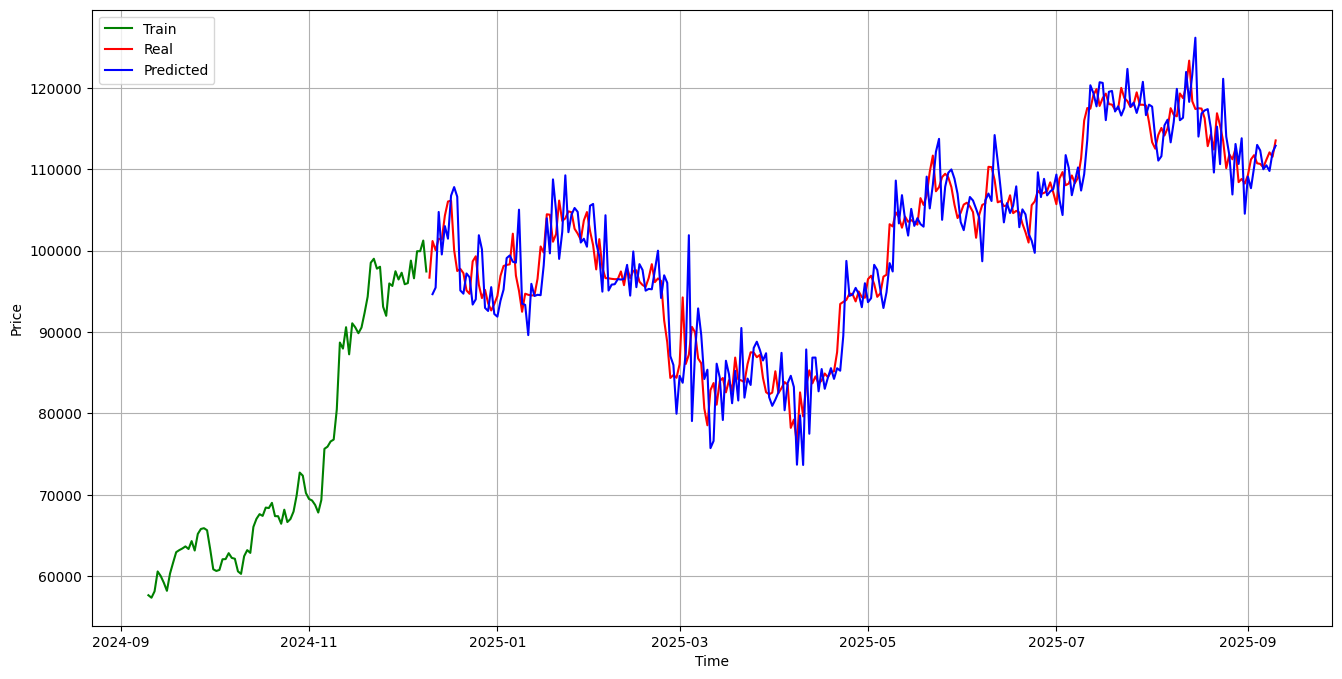

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(Ohlc['Close'].iloc[:window], color='green', label = 'Train')
plt.plot(y, color = 'red', label = 'Real')
plt.plot(preds, color = 'blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Evaluate the Direction Predicted by ARIMA

In [16]:
shiftby  = -1
predTarget = ( preds.shift(shiftby) - y ) > 0
predTarget = predTarget.astype(int)
predTarget = predTarget.iloc[ :shiftby ] if shiftby < 0 else predTarget.iloc[ shiftby: ]

In [17]:
index = predTarget.index.intersection( Target.index )

target     = Target.loc[ index ]
predTarget = predTarget.loc[ index ]

print( 'roc:', roc_auc_score( target, predTarget ))
print( 'accuracy:', accuracy_score( target, predTarget ))
print( 'f1:', f1_score( target, predTarget ))


roc: 0.5109489051094891
accuracy: 0.5109489051094891
f1: 0.5109489051094891
